In [10]:
import argparse
import glob
import os

import numpy as np
from imageio import imsave

from image import DepthImage

import tifffile

## From image.py it calls the DepthImage class and creates RGB and Depth Images

Note: The class "DepthImage" was modified so that it created RGB and Depth images. 
Original Code Source: https://github.com/skumra/robotic-grasping/blob/master/utils/dataset_processing/image.py 

In [19]:
# No need to call this again since the new RGB and Depth files have been created
"""
path = './data/01/'
pcds = glob.glob(os.path.join(path, 'pcd[0-9][0-9][0-9][0-9].txt'))  # Matches 'pcdXXXX.txt'
pcds.sort()

for pcd in pcds:
    di, rgb_img = DepthImage.from_pcd(pcd, (480, 640))
    
    # Save depth image
    depth_of_name = pcd.replace('.txt', '_depth.tiff')
    imwrite(depth_of_name, di.img.astype(np.float32))
    
    # Save RGB image
    rgb_of_name = pcd.replace('.txt', '_rgb.png')
    imwrite(rgb_of_name, rgb_img)
    """

"\npath = './data/01/'\npcds = glob.glob(os.path.join(path, 'pcd[0-9][0-9][0-9][0-9].txt'))  # Matches 'pcdXXXX.txt'\npcds.sort()\n\nfor pcd in pcds:\n    di, rgb_img = DepthImage.from_pcd(pcd, (480, 640))\n    \n    # Save depth image\n    depth_of_name = pcd.replace('.txt', '_depth.tiff')\n    imwrite(depth_of_name, di.img.astype(np.float32))\n    \n    # Save RGB image\n    rgb_of_name = pcd.replace('.txt', '_rgb.png')\n    imwrite(rgb_of_name, rgb_img)\n    "

## File verification 

1) verify that the file exists
2) get information about file

In [15]:
file_path = "./data/01/pcd0100_depth.tiff"
if os.path.exists(file_path):
    print("File exists!")
else:
    print("File not found.")

File exists!


In [16]:
try:
    with tifffile.TiffFile(file_path) as tif:
        print(tif.pages)  # Number of pages
        print("Image shape:", tif.pages[0].shape)  # Shape of first page
        print("Data type:", tif.pages[0].dtype)  # Data type
        print("Compression:", tif.pages[0].compression)  # Compression method
except Exception as e:
    print("Error:", e)

<tifffile.TiffPages @8>
Image shape: (480, 640)
Data type: float32
Compression: COMPRESSION.NONE


## Plot Original, RGB, and Depth Images to verify content

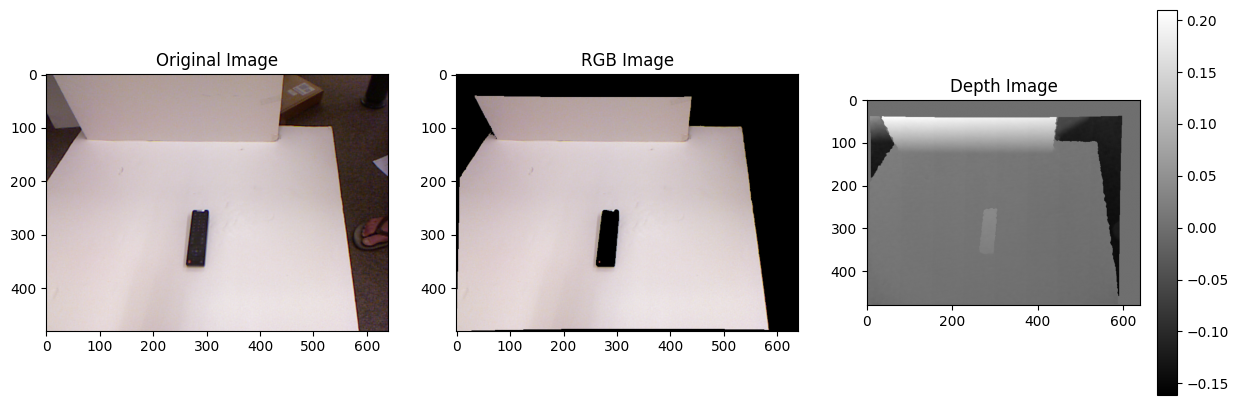

In [17]:
import cv2
import matplotlib.pyplot as plt

original = cv2.imread("./data/01/pcd0100r.png")
rgb = cv2.imread("./data/01/pcd0100_rgb.png")
depth = cv2.imread("./data/01/pcd0100_depth.tiff", cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
plt.title("RGB Image")

plt.subplot(1, 3, 3)
plt.imshow(depth, cmap='gray')
plt.colorbar()
plt.title("Depth Image")

plt.show()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import pandas as pd
import torch
import cv2
from PIL import Image
from IPython.display import display


# Combine RGB With Depth Images 
The previous code created 2 different images one was an RGB and the other one was a depth image. I came to the realization that I needed to combine these two into one single 4-channel TIFF file. The following function does that. 


In [3]:
import tifffile
def save_rgbd_as_tiff(rgb_img, depth_img, filename):
    """
    Save RGB-D as a multi-channel TIFF file.
    """
    # Ensure depth image is loaded and has the correct shape
    if depth_img is None or depth_img.size == 0:
        raise ValueError("Depth image is empty or not loaded correctly!")

    if rgb_img.shape[:2] != depth_img.shape:
        raise ValueError(f"Shape mismatch! RGB: {rgb_img.shape}, Depth: {depth_img.shape}")

    depth_img = depth_img.astype(np.float32)  # Keep full precision

    # Ensure depth is 3D by expanding dimensions
    depth_img = np.expand_dims(depth_img, axis=-1)  # Shape: (480, 640, 1)

    # Concatenate RGB and Depth into a single image (H, W, 4)
    rgbd_img = np.concatenate((rgb_img, depth_img), axis=-1)

    # Save as TIFF
    tifffile.imwrite(filename, rgbd_img)

# Example usage
rgb = cv2.imread("./data/01/pcd0100_rgb.png", 1) 
depth = cv2.imread("./data/01/pcd0100_depth.tiff", cv2.IMREAD_UNCHANGED) 
save_rgbd_as_tiff(rgb, depth, "00rgbd_pcd0100.tiff")

## Load Grasping Rectangles into the RGB-D image. 
I used some of Eric's code to achieve this

In [4]:
import cv2
import numpy as np
import tifffile
import pandas as pd

# Load the 4-channel RGB-D image from TIFF
rgbd = tifffile.imread("00rgbd_pcd0100.tiff")  # Ensure this is a 4-channel TIFF
print("Loaded RGB-D shape:", rgbd.shape)  # Expected shape: (480, 640, 4)

# Extract RGB and convert to YUV
rgb = rgbd[:, :, :3]  # First 3 channels are RGB
yuv = cv2.cvtColor(rgb, cv2.COLOR_BGR2YUV)  # Convert RGB to YUV

# Extract depth (4th channel)
depth = rgbd[:, :, 3]  # Last channel is Depth

print("YUV shape:", yuv.shape)  # Should be (480, 640, 3)
print("Depth shape:", depth.shape)  # Should be (480, 640)

# Load grasping rectangles
neg_rect_single = pd.read_csv("./data/01/pcd0100cneg.txt", delimiter='\s', header=None).to_numpy()
pos_rect_single = pd.read_csv("./data/01/pcd0100cpos.txt", delimiter='\s', header=None).to_numpy()

# Create a copy of the depth image for visualization
depth_with_rects = depth.copy()

# Draw grasping rectangles on depth image
for i in range(0, len(pos_rect_single), 4):
    rectangle_pts = np.array([
        [pos_rect_single[i, 0], pos_rect_single[i, 1]],
        [pos_rect_single[i + 1, 0], pos_rect_single[i + 1, 1]],
        [pos_rect_single[i + 2, 0], pos_rect_single[i + 2, 1]],
        [pos_rect_single[i + 3, 0], pos_rect_single[i + 3, 1]]
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(depth_with_rects, [rectangle_pts], isClosed=True, color=(255, 0, 0), thickness=1)

# Repeat for negative grasping rectangles
for i in range(0, len(neg_rect_single), 4):
    rectangle_pts = np.array([
        [neg_rect_single[i, 0], neg_rect_single[i, 1]],
        [neg_rect_single[i + 1, 0], neg_rect_single[i + 1, 1]],
        [neg_rect_single[i + 2, 0], neg_rect_single[i + 2, 1]],
        [neg_rect_single[i + 3, 0], neg_rect_single[i + 3, 1]]
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(depth_with_rects, [rectangle_pts], isClosed=True, color=(255, 0, 0), thickness=1)

# Merge RGB and modified Depth back into a 4-channel image
rgbd_with_rects = np.dstack((rgb, depth_with_rects))  # (480, 640, 4)

# ✅ Save as a 4-channel RGB-D TIFF
tifffile.imwrite("pcd0100_rgbd_with_rects_2.tiff", rgbd_with_rects.astype(np.float32))
print("Saved RGB-D with grasping rectangles as 4-channel TIFF.")


Loaded RGB-D shape: (480, 640, 4)
YUV shape: (480, 640, 3)
Depth shape: (480, 640)
Saved RGB-D with grasping rectangles as 4-channel TIFF.


/tmp/ipykernel_13730/2104703162.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  neg_rect_single = pd.read_csv("./data/01/pcd0100cneg.txt", delimiter='\s', header=None).to_numpy()
/tmp/ipykernel_13730/2104703162.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pos_rect_single = pd.read_csv("./data/01/pcd0100cpos.txt", delimiter='\s', header=None).to_numpy()


## Plot Results 
Note: notice that the vmax=0.1, this could be an indicator of the units that were used when the image was captured. 0.1 could mean 1meter away. Need to further investigate the units that were used

New RGB-D Shape: (480, 640, 4)


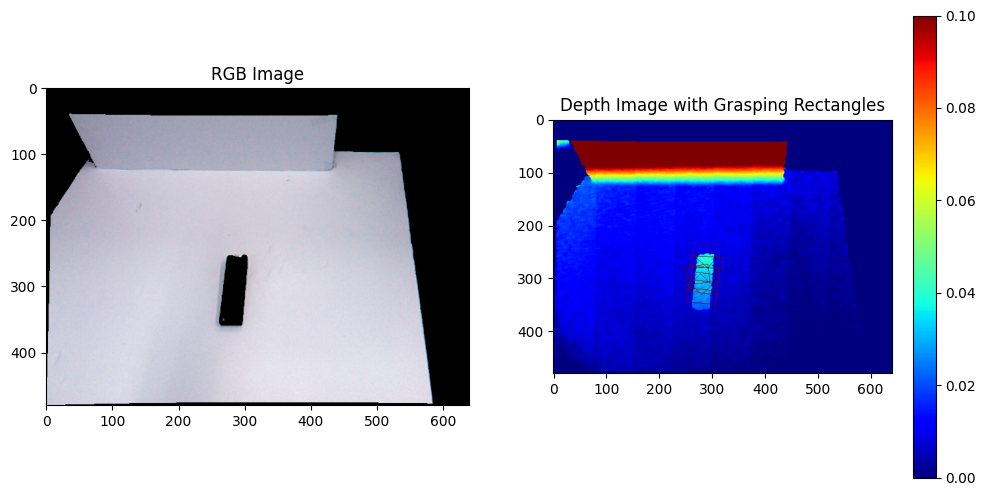

In [5]:
import tifffile

# Load the saved 4-channel RGB-D image
rgbd_new = tifffile.imread("pcd0100_rgbd_with_rects_2.tiff")

print("New RGB-D Shape:", rgbd_new.shape)  # Expected output: (480, 640, 4)

# Extract RGB and Depth for visualization
rgb_new = rgbd_new[:, :, :3]
depth_new = rgbd_new[:, :, 3]

# Visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(rgb_new.astype(np.uint8))
plt.title("RGB Image")


depth_new = np.clip(depth_new, 0, None) # there can't be negative values 



plt.subplot(1, 2, 2)
plt.imshow(depth_new, cmap='jet', vmin=0, vmax=.1) 
plt.colorbar()
plt.title("Depth Image with Grasping Rectangles")

plt.show()
